# Plot Mean Sea Level Pressure (PSL) contours

* **Description**: Reads in and creates monthly average
* **Input data**: Rufmod output in timeseries format
* **Output data**: png with drag figure
* **Creator**: Alice DuVivier
* **Date**: August 2022

The rufmod experiments were performed where the sea ice roughness over Arctic sea ice regions was set to be equal to what it would be over open ocean. This is to better understand ice-atmosphere coupling, processes, and feedbacks. The name of the experiments is "rufmod" but they include smoother ice and will be called "smooth" below.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
import pop_tools
from datetime import timedelta
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xesmf as xe

import dask
import intake
from distributed import Client
from ncar_jobqueue import NCARCluster

/glade/work/duvivier/miniconda3/envs/analysis2/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
# spin up dask cluster

import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=2, # The number of cores you want
    memory='32 GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    #resource_spec='select=1:ncpus=2:mem=256GB', # Specify resources
    project='P93300665', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)
# Scale up
cluster.scale(32)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.63:46159,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Manually set variables

In [4]:
# list the variables to load
var_in_1 = 'PSL'

## Load "smooth" experiments

In [5]:
# Load "rufmod" data
#choose cases and data paths
case1 = 'b.e21.BSSP370.f09_g17.rufmod.001'
case2 = 'b.e21.BSSP370.f09_g17.rufmod.002'
case3 = 'b.e21.BSSP370.f09_g17.rufmod.003'
case4 = 'b.e21.BSSP370.f09_g17.rufmod.004'
case5 = 'b.e21.BSSP370.f09_g17.rufmod.005'

# set base directory where all data live
data_dir = '/glade/campaign/cesm/development/pcwg/projects/arctic_cyclones/rufmod_expts/'
# set individual data directories
data_dir1 = data_dir+case1+'/atm/proc/tseries/month_1/'
data_dir2 = data_dir+case2+'/atm/proc/tseries/month_1/'
data_dir3 = data_dir+case3+'/atm/proc/tseries/month_1/'
data_dir4 = data_dir+case4+'/atm/proc/tseries/month_1/'
data_dir5 = data_dir+case5+'/atm/proc/tseries/month_1/'

In [9]:
%%time
#reading in files
print("loading "+var_in_1)   
ds1_1 = []
ds2_1 = []
ds3_1 = []
ds4_1 = []
ds5_1 = []
my_files=sorted(glob.glob(data_dir1+case1+'.cam.h0.'+var_in_1+'.*.nc'))
ds1_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir2+case2+'.cam.h0.'+var_in_1+'.*.nc'))
ds2_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir3+case3+'.cam.h0.'+var_in_1+'.*.nc'))
ds3_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')    
my_files=sorted(glob.glob(data_dir4+case4+'.cam.h0.'+var_in_1+'.*.nc'))
ds4_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')
my_files=sorted(glob.glob(data_dir5+case5+'.cam.h0.'+var_in_1+'.*.nc'))
ds5_1=xr.open_mfdataset(my_files,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal')

loading PSL
CPU times: user 1.18 s, sys: 164 ms, total: 1.34 s
Wall time: 42.3 s


In [15]:
# concatenate them into a single array
futures_1 = xr.concat([ds1_1,ds2_1,ds3_1,ds4_1,ds5_1],dim='member_id')

In [16]:
# set member_id values
futures_1.member_id.values
# assign member_id as coordinate array
futures_1.assign_coords({"member_id": futures_1.member_id.values})

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, member_id: 5, time: 1032, nbnd: 2, lon: 288, lev: 32, ilev: 33)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
  * member_id     (member_id) int64 0 1 2 3 4
Dimensions without coordinates: nbnd
Data variables: (12/27)
    zlon_bnds     (member_id, time, zlon, nbnd) float64 dask.array<chunksize=(1, 600, 1, 2), meta=np.ndarray>
    gw            (member_id, time, lat) float64 dask.array<chunksize=(1, 600, 192), meta=np.ndarray>
    hyam          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    hybm          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    P0            (member_id, time) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    hyai          (member_id, time, ilev) float64 dask.array<chunksize=(1, 600, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f11vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f12vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    sol_tsi       (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    nsteph        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    PSL           (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSSP370.f09_g17.rufmod.001
    logname:           duvivier
    host:              cheyenne3
    initial_file:      b.e21.BHIST.f09_g17.CMIP6-historical.rufmod.cam.i.2015...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [17]:
futures_1

<xarray.Dataset>
Dimensions:       (lat: 192, zlon: 1, member_id: 5, time: 1032, nbnd: 2, lon: 288, lev: 32, ilev: 33)
Coordinates:
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * zlon          (zlon) float64 0.0
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Dimensions without coordinates: member_id, nbnd
Data variables: (12/27)
    zlon_bnds     (member_id, time, zlon, nbnd) float64 dask.array<chunksize=(1, 600, 1, 2), meta=np.ndarray>
    gw            (member_id, time, lat) float64 dask.array<chunksize=(1, 600, 192), meta=np.ndarray>
    hyam          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    hybm          (member_id, time, lev) float64 dask.array<chunksize=(1, 600, 32), meta=np.ndarray>
    P0            (member_id, time) float64 1e+05 1e+05 1e+05 ... 1e+05 1e+05
    hyai          (member_id, time, ilev) float64 dask.array<chunksize=(1, 600, 33), meta=np.ndarray>
    ...            ...
    n2ovmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f11vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    f12vmr        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    sol_tsi       (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    nsteph        (member_id, time) float64 dask.array<chunksize=(1, 600), meta=np.ndarray>
    PSL           (member_id, time, lat, lon) float32 dask.array<chunksize=(1, 600, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              b.e21.BSSP370.f09_g17.rufmod.001
    logname:           duvivier
    host:              cheyenne3
    initial_file:      b.e21.BHIST.f09_g17.CMIP6-historical.rufmod.cam.i.2015...
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [18]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
futures_1['time'] = futures_1.time_bnds.load().mean(dim='nbnd').sel(member_id=0)

In [19]:
futures_1.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00

In [20]:
psl_smooth = futures_1[var_in_1]

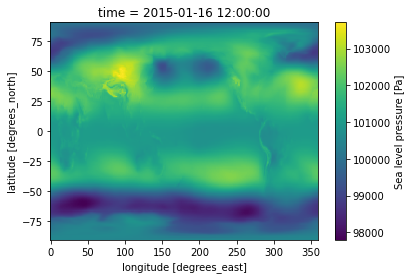

In [21]:
psl_smooth.sel(member_id=0).isel(time=0).plot()

## Read the CESM-LE data 

We will use [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/), which is a data catalog tool.
It enables querying a database for the files we want, then loading those directly as an `xarray.Dataset`.

First step is to set the "collection" for the CESM-LE, which depends on a json file conforming to the [ESM Catalog Specification](https://github.com/NCAR/esm-collection-spec).

In [22]:
catalog_file = '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'

cat = intake.open_esm_datastore(catalog_file)

/glade/work/duvivier/miniconda3/envs/analysis2/lib/python3.7/site-packages/intake_esm/core.py:84: DtypeWarning: Columns (5,6,9) have mixed types.Specify dtype option on import or set low_memory=False.
  self._df, self.catalog_file = _fetch_catalog(self.esmcol_data, esmcol_obj, csv_kwargs)


In [32]:
forcing = 'cmip6'  # do not want smbb data
expt = 'ssp370'
freq = 'month_1'

subset_1 = cat.search(variable=var_in_1, forcing_variant=forcing, experiment=expt, frequency=freq )


In [33]:
# check that we only have cmip6, not smbb, data
member_id = list(subset_1.df.experiment.unique())
print(member_id)

['ssp370']


In [34]:
%%time
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    dsets_1 = subset_1.to_dataset_dict(cdf_kwargs={'chunks': {'time':240}, 'decode_times': True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 7.64 s, sys: 187 ms, total: 7.83 s
Wall time: 8.87 s


In [35]:
# load in the future datasets
futures_1 = []
for key in sorted(dsets_1.keys()):
    futures_1.append(dsets_1[key])
    print(key)

atm.ssp370.cam.h0.cmip6.PSL


In [36]:
future_ds_1 = xr.concat(futures_1, dim='member_id')

In [37]:
future_ds_1.time

<xarray.DataArray 'time' (time: 1032)>
array([cftime.DatetimeNoLeap(2015, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2015, 4, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 2015-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds

In [38]:
# Shift months by one to be center of time period.
# Take average of the time bounds to get middle of month
# will lose some attributes with time, so may need to put this back in later...
future_ds_1['time'] = future_ds_1.time_bnds.load().mean(dim='nbnd').sel(member_id='r1i1281p1f1')

In [39]:
psl_le = future_ds_1[var_in_1]

In [40]:
psl_le.persist()

,Array,Chunk
Bytes,10.63 GiB,25.31 MiB
Shape,"(50, 1032, 192, 288)","(1, 120, 192, 288)"
Count,450 Tasks,450 Chunks
Type,float32,numpy.ndarray


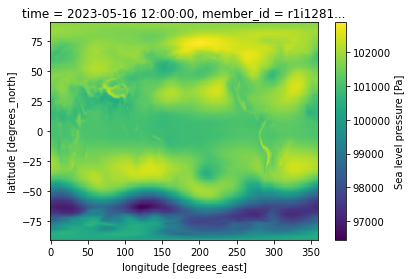

In [41]:
psl_le.sel(member_id='r1i1281p1f1').isel(time=100).plot()

## Convert both to hPa from Pa

In [42]:
psl_smooth = psl_smooth/100.
psl_le = psl_le/100.

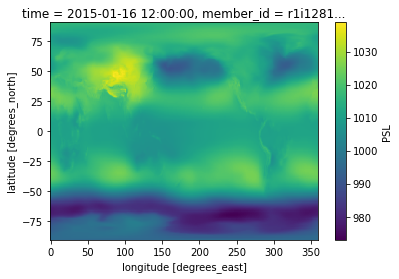

In [44]:
psl_le.sel(member_id='r1i1281p1f1').isel(time=0).plot()

## Calculate seasonal means

In [45]:
season_names = ['OND','JFM', 'AMJ', 'JAS','ANN']

In [46]:
# find total years
xarr_le = psl_le.coords['time.year'][(psl_le.coords['time.month']==1)]
xarr_smooth = psl_smooth.coords['time.year'][(psl_smooth.coords['time.month']==1)]

In [47]:
# Loop through seasons - rufmod

# make numpy array to fill and specify dimensions we want
seas_array_smooth = np.zeros([len(season_names),len(xarr_smooth),len(psl_smooth.member_id),len(psl_smooth.lat),len(psl_smooth.lon)])

for ss in season_names:
    print(ss)
    if ss == 'OND':
        s_count = 0
    else: 
        s_count = s_count+1
    # get temporary array of just these month by season
    if ss == 'JFM':
        temp1 = psl_smooth.isel(time=psl_smooth.time.dt.month.isin([1,2,3]))
    if ss == 'AMJ':
        temp1 = psl_smooth.isel(time=psl_smooth.time.dt.month.isin([4,5,6]))
    if ss == 'JAS':
        temp1 = psl_smooth.isel(time=psl_smooth.time.dt.month.isin([7,8,9]))
    if ss == 'OND':
        temp1 = psl_smooth.isel(time=psl_smooth.time.dt.month.isin([10,11,12]))
    if ss == 'ANN':
        temp1 = psl_smooth        
    # now loop through years to get the seasonal average by year for each ensemble member
    for yy in xarr_smooth:
        if yy == 2015:
            y_count = 0
        else: 
            y_count = y_count+1 
        # select only the indexes for this year
        temp2 = temp1.isel(time=temp1.time.dt.year.isin([yy]))
        temp3 = temp2.mean(dim='time')
        seas_array_smooth[s_count,y_count,:,:,:] = temp3    


OND
JFM
AMJ
JAS
ANN


In [48]:
# Loop through seasons - CESM2-LE

# make numpy array to fill and specify dimensions we want
seas_array_le = np.zeros([len(season_names),len(xarr_le),len(psl_le.member_id),len(psl_le.lat),len(psl_le.lon)])

for ss in season_names:
    print(ss)
    if ss == 'OND':
        s_count = 0
    else: 
        s_count = s_count+1
    # get temporary array of just these month by season
    if ss == 'JFM':
        temp1 = psl_le.isel(time=psl_le.time.dt.month.isin([1,2,3]))
    if ss == 'AMJ':
        temp1 = psl_le.isel(time=psl_le.time.dt.month.isin([4,5,6]))
    if ss == 'JAS':
        temp1 = psl_le.isel(time=psl_le.time.dt.month.isin([7,8,9]))
    if ss == 'OND':
        temp1 = psl_le.isel(time=psl_le.time.dt.month.isin([10,11,12]))
    if ss == 'ANN':
        temp1 = psl_le        
    # now loop through years to get the seasonal average by year for each ensemble member
    for yy in xarr_le:
        if yy == 2015:
            y_count = 0
        else: 
            y_count = y_count+1 
        # select only the indexes for this year
        temp2 = temp1.isel(time=temp1.time.dt.year.isin([yy]))
        temp3 = temp2.mean(dim='time')
        seas_array_le[s_count,y_count,:,:,:] = temp3    


OND
JFM
AMJ
JAS
ANN


In [49]:
print(seas_array_le.shape)
print(seas_array_smooth.shape)

(5, 86, 50, 192, 288)
(5, 86, 5, 192, 288)


In [50]:
psl_le

,Array,Chunk
Bytes,10.63 GiB,25.31 MiB
Shape,"(50, 1032, 192, 288)","(1, 120, 192, 288)"
Count,2700 Tasks,450 Chunks
Type,float32,numpy.ndarray


In [51]:
# convert the numpy array to a xarray for easier plotting
psl_seas_le = xr.DataArray(seas_array_le,dims=('season','time','member_id','lat','lon'))
psl_seas_smooth = xr.DataArray(seas_array_smooth,dims=('season','time','member_id','lat','lon'))

In [52]:
# set coordinate arrays
psl_seas_le['season'] = season_names
psl_seas_le['time'] = xarr_le
psl_seas_le['member_id'] = psl_le['member_id']
psl_seas_le['lat'] = psl_le['lat'].values
psl_seas_le['lon'] = psl_le['lon'].values

psl_seas_smooth['season'] = season_names
psl_seas_smooth['time'] = xarr_smooth
psl_seas_smooth['member_id'] = psl_smooth['member_id']
psl_seas_smooth['lat'] = psl_smooth['lat'].values
psl_seas_smooth['lon'] = psl_smooth['lon'].values

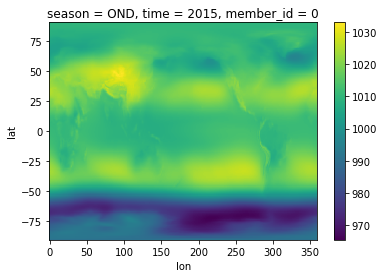

In [54]:
psl_seas_smooth.isel(season=0,time=0,member_id=0).plot()

In [56]:
psl_seas_smooth

<xarray.DataArray (season: 5, time: 86, member_id: 5, lat: 192, lon: 288)>
array([[[[[ 990.70526123,  990.70526123,  990.70526123, ...,
            990.70526123,  990.70526123,  990.70526123],
          [ 991.79077148,  991.80371094,  991.81414795, ...,
            991.74334717,  991.76031494,  991.77630615],
          [ 991.88702393,  991.92169189,  991.95623779, ...,
            991.7756958 ,  991.81500244,  991.85229492],
          ...,
          [1009.33172607, 1009.33380127, 1009.33526611, ...,
           1009.32568359, 1009.32739258, 1009.3293457 ],
          [1009.45599365, 1009.45794678, 1009.46087646, ...,
           1009.45037842, 1009.45257568, 1009.45452881],
          [1009.58569336, 1009.58569336, 1009.58569336, ...,
           1009.58569336, 1009.58569336, 1009.58569336]],

         [[ 993.38006592,  993.38006592,  993.38006592, ...,
            993.38006592,  993.38006592,  993.38006592],
          [ 994.30096436,  994.31268311,  994.32220459, ...,
            994.25921631,  994.27410889,  994.28833008],
          [ 994.16040039,  994.19061279,  994.22021484, ...,
            994.06713867,  994.09967041,  994.13104248],
...
          [1008.86407471, 1008.85180664, 1008.83959961, ...,
           1008.90216064, 1008.8894043 , 1008.87664795],
          [1008.99713135, 1008.99029541, 1008.9833374 , ...,
           1009.01739502, 1009.01055908, 1009.00390625],
          [1009.17694092, 1009.17694092, 1009.17694092, ...,
           1009.17694092, 1009.17694092, 1009.17694092]],

         [[ 996.52679443,  996.52679443,  996.52679443, ...,
            996.52679443,  996.52679443,  996.52679443],
          [ 997.35455322,  997.36602783,  997.37579346, ...,
            997.31158447,  997.32696533,  997.34204102],
          [ 996.99627686,  997.03851318,  997.08197021, ...,
            996.86383057,  996.90942383,  996.95391846],
          ...,
          [1010.58355713, 1010.57330322, 1010.56329346, ...,
           1010.61645508, 1010.60498047, 1010.59405518],
          [1010.98583984, 1010.97827148, 1010.97113037, ...,
           1011.00897217, 1011.00115967, 1010.99346924],
          [1011.30883789, 1011.30883789, 1011.30883789, ...,
           1011.30883789, 1011.30883789, 1011.30883789]]]]])
Coordinates:
  * season     (season) <U3 'OND' 'JFM' 'AMJ' 'JAS' 'ANN'
  * time       (time) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
  * member_id  (member_id) int64 0 1 2 3 4
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

## Calculate decadal and ensemble means

In [106]:
#specify some arrays that will become coordinate arrays
decades = list(range(2020,2100,10))
decade_names = ['2020','2030','2040','2050','2060','2070','2080','2090']

In [107]:
decades

[2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090]

In [109]:
# Loop through decades - rufmod
print('Calculating Decadal and Ensemble Means - SMOOTH')

# make numpy array to fill and specify dimensions we want
array_smooth = np.zeros([len(decades),len(season_names),len(psl_seas_smooth.lat),len(psl_seas_smooth.lon)])

# decade loop
for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 2020:
        count = 0
    else: 
        count = count+1
    # set the start and end years for this decade
    yy_st = dec
    yy_ed = yy_st + 10
    yy = list(range(yy_st,yy_ed,1))
    # subset the data for these years only but keep all months
    temp1 = psl_seas_smooth.isel(time=psl_seas_smooth.time.isin([yy]))
    # stack so we can average over years and ensembles at once
    temp2 = temp1.stack(all_times=("time","member_id"))
    # average over everything
    array_smooth[count,:,:,:] = temp2.mean(dim='all_times')
        

Calculating Decadal and Ensemble Means - SMOOTH
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


In [110]:
# Loop through decades - CESM2-LE
print('Calculating Decadal and Ensemble Means - CESM2-LE')

# make numpy array to fill and specify dimensions we want
array_le = np.zeros([len(decades),len(season_names),len(psl_seas_le.lat),len(psl_seas_le.lon)])

# decade loop
for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 2020:
        count = 0
    else: 
        count = count+1
    # set the start and end years for this decade
    yy_st = dec
    yy_ed = yy_st + 10
    yy = list(range(yy_st,yy_ed,1))
    # subset the data for these years only but keep all months
    temp1 = psl_seas_le.isel(time=psl_seas_le.time.isin([yy]))
    # stack so we can average over years and ensembles at once
    temp2 = temp1.stack(all_times=("time","member_id"))
    # average over everything
    array_le[count,:,:,:] = temp2.mean(dim='all_times')
        

Calculating Decadal and Ensemble Means - CESM2-LE
Calculating decadal means for 2020s
Calculating decadal means for 2030s
Calculating decadal means for 2040s
Calculating decadal means for 2050s
Calculating decadal means for 2060s
Calculating decadal means for 2070s
Calculating decadal means for 2080s
Calculating decadal means for 2090s


In [111]:
print(array_smooth.shape)
print(array_le.shape)

(8, 5, 192, 288)
(8, 5, 192, 288)


In [112]:
# convert the numpy array to a xarray for easier plotting
psl_seas_dec_le = xr.DataArray(array_le,dims=('decades','season','lat','lon'))
psl_seas_dec_smooth = xr.DataArray(array_smooth,dims=('decades','season','lat','lon'))

In [113]:
# set coordinate arrays
psl_seas_dec_le['decades'] = decade_names
psl_seas_dec_le['season'] = season_names
psl_seas_dec_le['lat'] = psl_seas_le['lat'].values
psl_seas_dec_le['lon'] = psl_seas_le['lon'].values

psl_seas_dec_smooth['decades'] = decade_names
psl_seas_dec_smooth['season'] = season_names
psl_seas_dec_smooth['lat'] = psl_seas_smooth['lat'].values
psl_seas_dec_smooth['lon'] = psl_seas_smooth['lon'].values

## Mask everything below 70N

In [132]:
psl_seas_dec_le = psl_seas_dec_le.where(psl_seas_dec_le.lat >70)
psl_seas_dec_smooth = psl_seas_dec_smooth.where(psl_seas_dec_smooth.lat >70)

## Plotting

### General plotting data

In [133]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

### Now Plot - spatial plots by decade

In [142]:
season_names[4:5]

['ANN']

Plotting season ANN


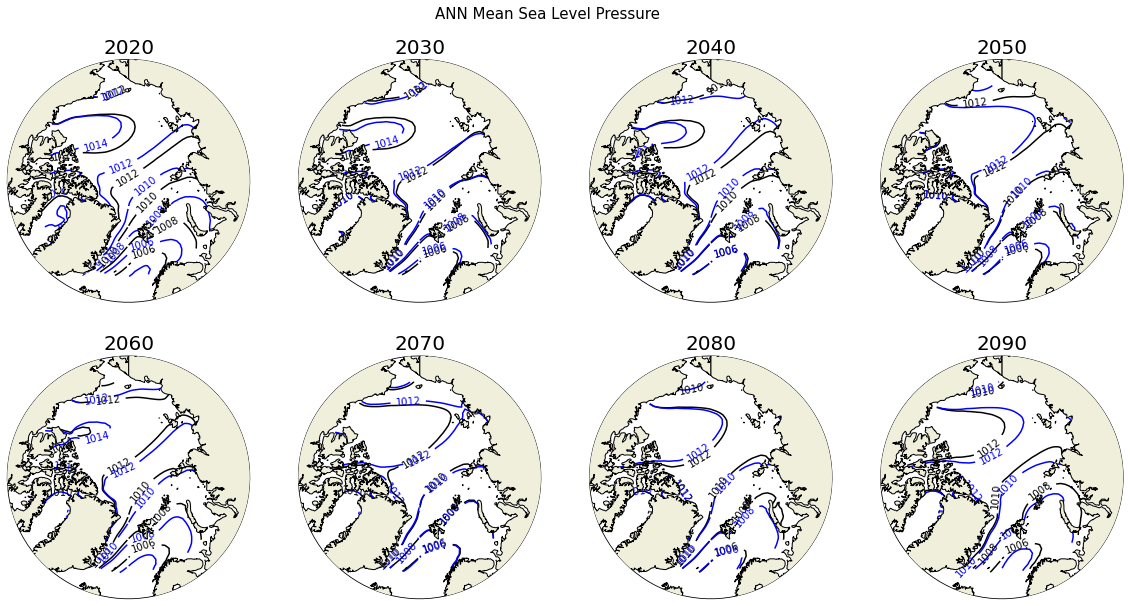

In [143]:
# set units
units = 'hPa'

#Plot each season and percent difference
levels_in = np.arange(950,1050,2)  

for ss in season_names[4:5]:
    print('Plotting season '+ss)
    
    # create figure
    fig = plt.figure(figsize=(20,10))
    fout = 'decadal_'+var_in_1+'_'+ss
    title = ss+' Mean Sea Level Pressure'
    
    for dd in decade_names:
        if dd == '2020':
            count = 1
        else: 
            count = count+1
        #print('Plotting drag for '+dd)
        # grab data to plot
        temp_le = psl_seas_dec_le.sel(decades=dd,season=ss)
        temp_smooth = psl_seas_dec_smooth.sel(decades=dd,season=ss)
        
        # Make subplots - note it's nrow x ncol x index (starting upper left)
        ax = fig.add_subplot(2,4,count, projection=ccrs.NorthPolarStereo())
        ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())

        #CESM2-LE
        color = 'black'
        this = ax.contour(temp_le.lon,temp_le.lat,
                          temp_le,
                          transform=ccrs.PlateCarree(),
                          colors = color, levels = levels_in)
        plt.clabel(this,colors=color,inline=1,fontsize=10,levels=levels_in)
        #SMOOTH
        color = 'blue'
        this = ax.contour(temp_smooth.lon,temp_smooth.lat,
                          temp_smooth,
                          transform=ccrs.PlateCarree(),
                          colors = color, levels = levels_in)
        plt.clabel(this,colors=color,inline=1,fontsize=10,levels=levels_in)
        # add title
        plt.title(dd,fontsize=20)

    # Finalize figure and save
    fig.suptitle(title,fontsize=15, y=0.95)  
    #fig.subplots_adjust(bottom=0.45,wspace=0.1)
    fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200) 


Plotting season OND
Plotting season JFM
Plotting season AMJ
Plotting season JAS


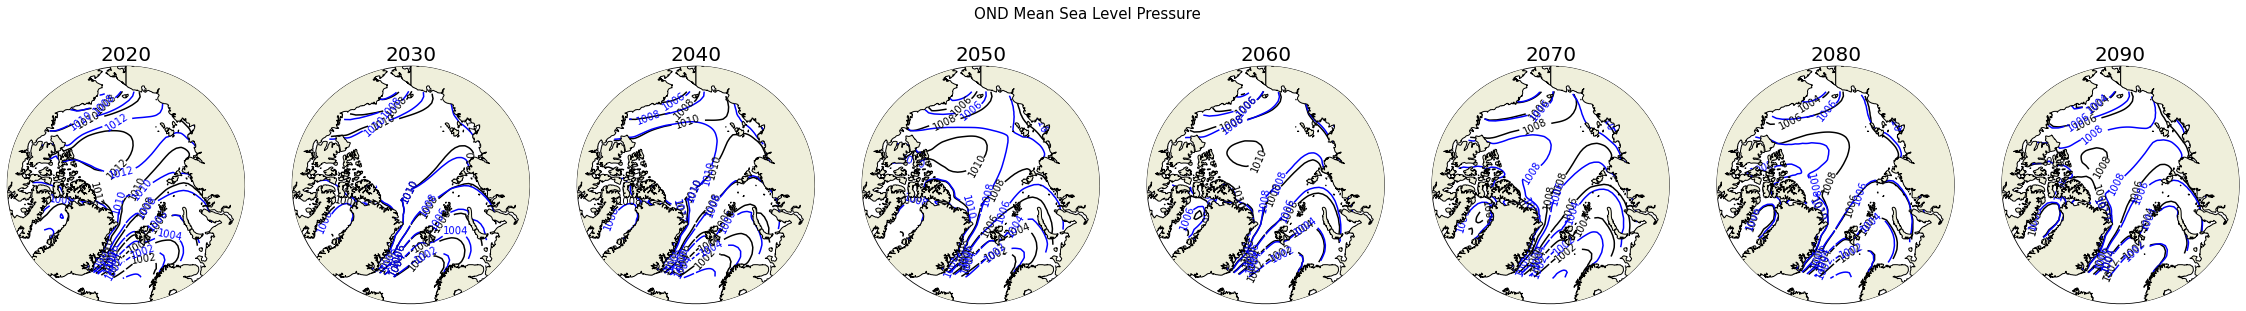

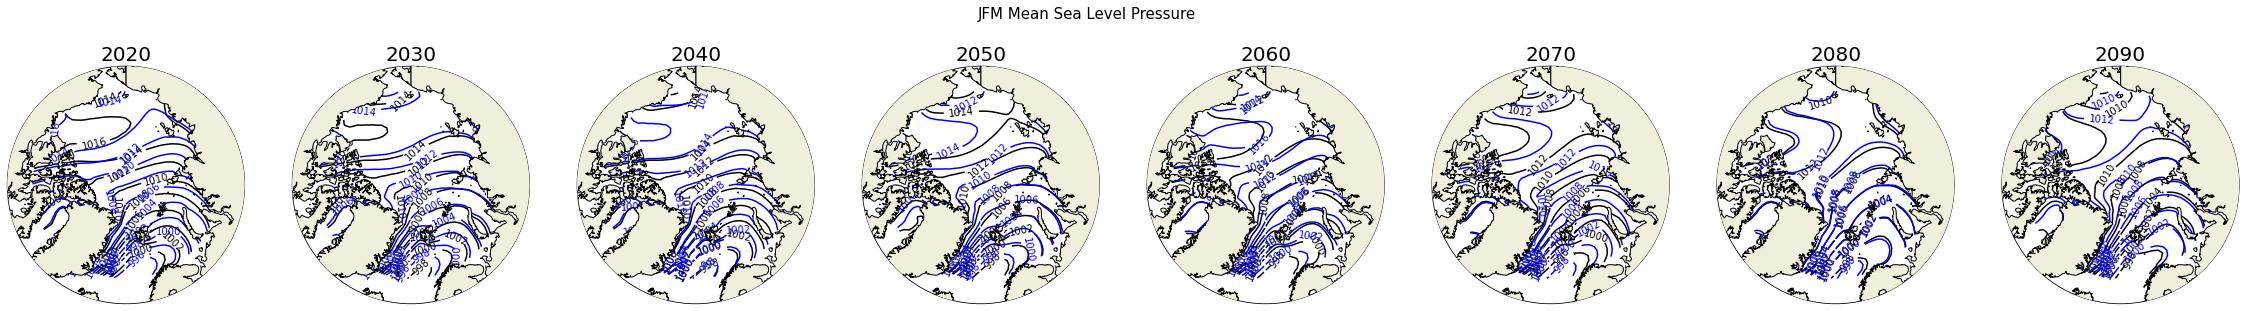

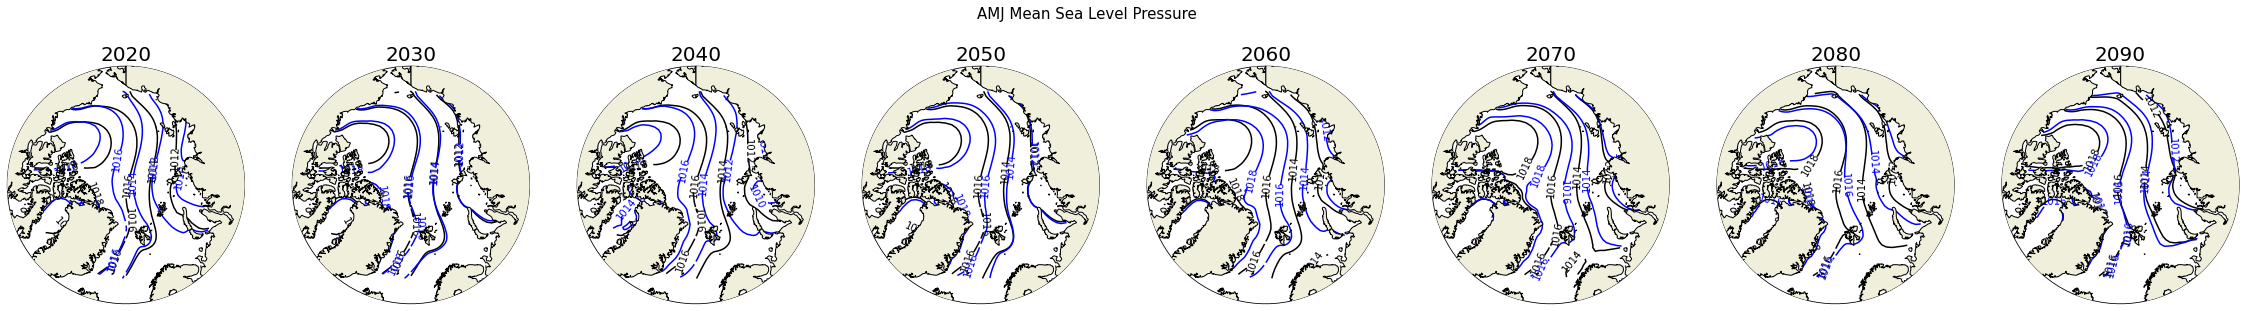

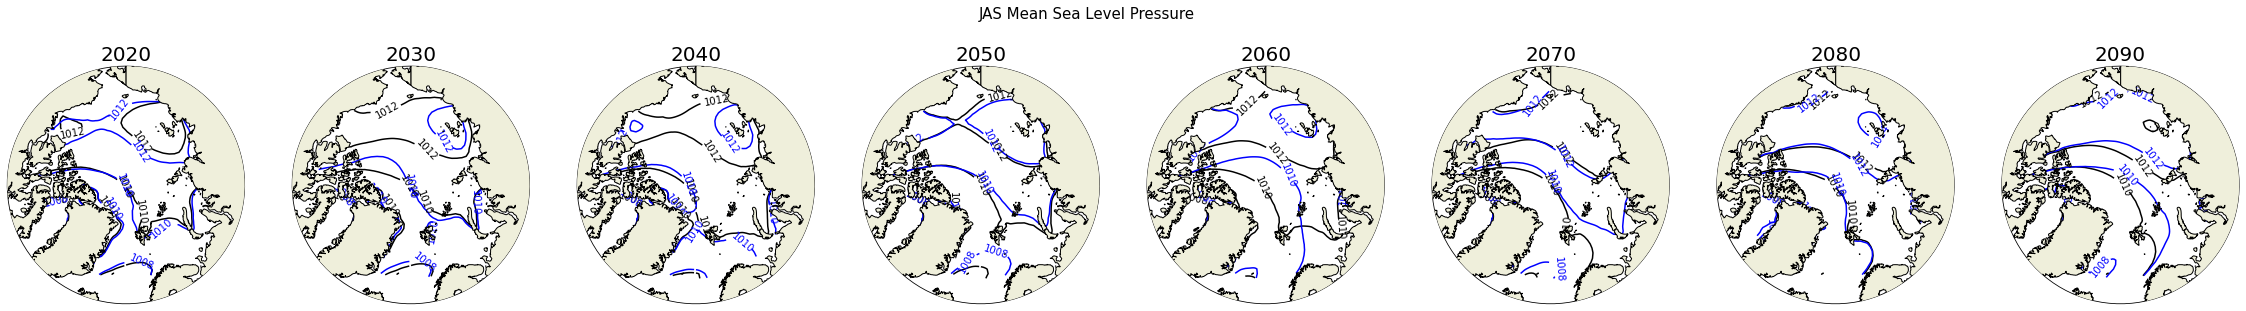

In [154]:
# set units
units = 'hPa'

#Plot each season and percent difference
levels_in = np.arange(950,1050,2)  

for ss in season_names[0:4]:
    print('Plotting season '+ss)
    
    # create figure
    fig = plt.figure(figsize=(40,10))
    fout = 'decadal_'+var_in_1+'_'+ss
    title = ss+' Mean Sea Level Pressure'
    
    for dd in decade_names:
        if dd == '2020':
            count = 1
        else: 
            count = count+1
        #print('Plotting drag for '+dd)
        # grab data to plot
        temp_le = psl_seas_dec_le.sel(decades=dd,season=ss)
        temp_smooth = psl_seas_dec_smooth.sel(decades=dd,season=ss)
        
        # Make subplots - note it's nrow x ncol x index (starting upper left)
        ax = fig.add_subplot(1,8,count, projection=ccrs.NorthPolarStereo())
        ax.add_feature(cfeature.LAND,zorder=100,edgecolor='k')
        ax.set_boundary(circle, transform=ax.transAxes)
        ax.set_extent([0.005, 360, 90, 65], crs=ccrs.PlateCarree())

        #CESM2-LE
        color = 'black'
        this = ax.contour(temp_le.lon,temp_le.lat,
                          temp_le,
                          transform=ccrs.PlateCarree(),
                          colors = color, levels = levels_in)
        plt.clabel(this,colors=color,inline=1,fontsize=10,levels=levels_in)
        #SMOOTH
        color = 'blue'
        this = ax.contour(temp_smooth.lon,temp_smooth.lat,
                          temp_smooth,
                          transform=ccrs.PlateCarree(),
                          colors = color, levels = levels_in)
        plt.clabel(this,colors=color,inline=1,fontsize=10,levels=levels_in)
        # add title
        plt.title(dd,fontsize=20)

    # Finalize figure and save
    fig.suptitle(title,fontsize=15, y=0.75)  
    #fig.subplots_adjust(bottom=0.45,wspace=0.1)
    fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200) 
